# Exploratory Data and Feature Analysis FCDO

This notebook is meant to roughly explore the features and their relation with conflict outbreak.We fit a random forest model to see which value have the most predictive power when predicting conflict. The variables most capable of predicting conflict are also the ones deemed capable of explaining conflict in causal terms. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import logging.config
import difflib as dl
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_colwidth = 100 #To see all feature names completely

In [39]:
# Change default plot size
plt.rcParams['figure.figsize'] = (15, 7)

# Set display settings
rc = {'lines.linewidth': 2, 'font.sans-serif': ['DejaVu Sans']}
sns.set_context('notebook', rc=rc, font_scale=1.25)
sns.set_style('whitegrid', rc=rc)

In [3]:
root = './Data/'
file = 'FCDO_data.csv'
data = pd.read_csv(root+file)

## Feature Engineering

In [5]:
class Prepare_Data:
    def __init__(self, data):
        """
        Class function to preprocess data to data that can we used for feature engineering. Imports the raw data and exports data that 
        immediatly fits random forest model. Since we are using random forest model, it is not necessary to scale data. Random forest models
        ares also able to deal with colinearity within features. Also since there are so many columns we do not rename them yet.
        :param :
        :param :
        """
            # Create logger
        log_format = '%(asctime)s - %(name)s - %(levelname)s - %(funcName)s - %(message)s'
        logging.basicConfig(format=log_format, level=logging.INFO, stream=sys.stdout)
        logger = logging.getLogger()
        self.data = data
        self.logger = logging.getLogger(__name__)

    def prepare_data(self):
        """
        This functions starts the pre processing activities for the random forest model
        :return:
        """
        self.logger.info("start preprocessing data")

        # Change the object types
        self.change_object_type()
        # Deal with awkward column string names
        self.deal_with_string_column_names()
        # Add new features based on range
        self.include_range_data()
        # Deal with missing data
        self.deal_with_missing_data()

        return self.data

    def change_object_type(self):
        """
        Since all the data are floats, we convert the data type.
        :return:
        """

        self.logger.info("start initiating data")
        data = self.data

        # Eliminate all rows where there is no sales price present
        data.replace(['--'], [np.nan], inplace=True)  # replace -- by np.nan
        data.loc[:, data.columns != 'ADM3_EN'] = data.loc[:, data.columns != 'ADM3_EN'].apply(pd.to_numeric, errors='raise')
        self.data=data

    def deal_with_string_column_names(self):
        """
        This functions adjusts column names.
        :return:
        """

        self.logger.info("deal with missing data")
        data = self.data
        
        # #Strip symbols from column names for efficient column selection
        data.columns = data.columns.str.replace("'","")
        data.columns = data.columns.str.replace("''","")
        data.columns = data.columns.str.replace("(","")
        data.columns = data.columns.str.replace(")","")

        self.data = data

    def include_range_data(self):
        """
        Create new features based on range between the minimum and the maximum value of that feature.
        :return:
        """

        self.logger.info("Start adding range features.")
        data = self.data
        
        # Find columns minimums and maximums. (Note: there are no min/max columns (without capital letter))
        min_cols = [col for col in data.columns if 'Min' in col]
        max_cols = [col for col in data.columns if 'Max' in col]
        
        # Find which column from min corresponds with max: #https://docs.python.org/3/library/difflib.html#difflib.get_close_matches
        for min_col in min_cols:
            max_col = dl.get_close_matches(min_col, max_cols, n=1)[0]
            rangename=min_col.replace('Min','Range')
            data[rangename] = data[max_col]-data[min_col]

        self.data=data
        
    def deal_with_missing_data(self):
        """
        This functions deals with missing data and replaces it with the nodes. 
        :return:
        """

        self.logger.info("deal with missing data")
        data = self.data
        
        #Replace inf by NaN values
        data.replace([np.inf, -np.inf], np.nan, inplace=True)
        
        #Fill NaN values
        data.fillna(data.mean(), inplace=True)
        
        self.data = data



## Random Forest Model

In [6]:
class ForecastModel:
    def __init__(self, data):
        """
        :param data:
        """
        self.logger = logging.getLogger(__name__)
        self.fatalities_columns = ['Year Made','Machine Size','Model Description','Auctioneer ID', 'Model ID','Coupler']
        self.data = data
        self.dependent_variable = 'total_fatalities, '
        self.non_prediction_variables = ['ADM3_EN','total_fatalities, ']
        self.feature_performance = pd.DataFrame(columns={'Feature_name', 'Feature_importance'})

    def calculate(self):
        """
        This functions starts the individual functions for running and evaluating the machine learning model
        :return:
        """
        self.logger.info("start training and predicting module")

        # Split the data set into train and test
        self.split_data()
        # train the model
        self.fit_model()
        # Make predictions after training
        self.predict_model()
        # Return the R2 ans RMSE performance of the model
        self.return_performance()
        # Return the performance of the individual features
        self.feature_scoring()

        return self.R2, self.RMSE, self.feature_performance

    def split_data(self):
        """
        Splits data into training and test (use 'rule of thumb' 4/5 for training)
        :return:
        """
        self.logger.info("start splitting data")
        X = self.data.loc[:,~(self.data.columns.isin(self.non_prediction_variables))]
        y = self.data.loc[:,self.dependent_variable]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=3)

    def fit_model(self):
        """
        Fit the model
        :return:
        """
        self.logger.info("start fitting model")
        # No additional parameters given
        model = RandomForestRegressor()
        model.fit(self.X_train , self.y_train)
        self.model=model

    def predict_model(self):
        """
        Make predictions with the trained model.
        """
        self.logger.info("start predicting model")
        self.y_test_predict = self.model.predict(self.X_test)

    def return_performance(self):
        """
        Return overal performance in the form of RMSE and R2 score.
        """
        self.logger.info("start returning performance")
        self.RMSE = (np.sqrt(mean_squared_error(self.y_test, self.y_test_predict)))
        self.R2 = (r2_score(self.y_test, self.y_test_predict))

    def feature_scoring(self):
        """
        Return feature performance by inbuilt function.
        """
        self.logger.info("start returning feature scoring")
        feature_performance = self.feature_performance
        feature_performance['Feature_importance'] = self.model.feature_importances_
        for i in range(0,len(feature_performance)):
            feature_performance.loc[i,'Feature_name']=self.X_train.columns[i]

        self.feature_performance=feature_performance



## Applying Models

In [7]:
pre_processing = Prepare_Data(data)
prepared_data = pre_processing.prepare_data()

2021-12-20 09:20:39,780 - __main__ - INFO - prepare_data - start preprocessing data
2021-12-20 09:20:39,782 - __main__ - INFO - change_object_type - start initiating data
2021-12-20 09:20:39,915 - __main__ - INFO - deal_with_string_column_names - deal with missing data
2021-12-20 09:20:39,918 - __main__ - INFO - include_range_data - Start adding range features.


/tmp/ipykernel_49/1726550530.py:61: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data.columns = data.columns.str.replace("(","")
/tmp/ipykernel_49/1726550530.py:62: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data.columns = data.columns.str.replace(")","")
/tmp/ipykernel_49/1726550530.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[rangename] = data[max_col]-data[min_col]


2021-12-20 09:20:40,625 - __main__ - INFO - deal_with_missing_data - deal with missing data


/tmp/ipykernel_49/1726550530.py:100: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.fillna(data.mean(), inplace=True)


In [8]:
RF_model = ForecastModel(prepared_data)
R2, RMSE, feature_performance=RF_model.calculate()

2021-12-20 09:20:40,710 - __main__ - INFO - calculate - start training and predicting module
2021-12-20 09:20:40,710 - __main__ - INFO - split_data - start splitting data
2021-12-20 09:20:40,713 - __main__ - INFO - fit_model - start fitting model
2021-12-20 09:20:43,731 - __main__ - INFO - predict_model - start predicting model
2021-12-20 09:20:43,746 - __main__ - INFO - return_performance - start returning performance
2021-12-20 09:20:43,748 - __main__ - INFO - feature_scoring - start returning feature scoring


In [9]:
feature_performance.sort_values('Feature_importance', ascending=False, inplace=True)

In [10]:
feature_performance.set_index('Feature_name', inplace=True)

## Run Model without Fatalities columns

In [11]:
data2 = pd.read_csv(root+file)
data2.head(5)

,ADM3_EN,IDAHO_EPSCOR_TERRACLIMATE_Max_Climate_Water_Deficit,IDAHO_EPSCOR_TERRACLIMATE_SD_Max_Climate_Water_Deficit,IDAHO_EPSCOR_TERRACLIMATE_Mean_Climate_Water_Deficit,IDAHO_EPSCOR_TERRACLIMATE_SD_Mean_Climate_Water_Deficit,IDAHO_EPSCOR_TERRACLIMATE_Min_Climate_Water_Deficit,IDAHO_EPSCOR_TERRACLIMATE_SD_Min_Climate_Water_Deficit,ECMWF_ERA5_LAND_MONTHLY_Max_Evaporation_Bare,ECMWF_ERA5_LAND_MONTHLY_SD_Max_Evaporation_Bare,ECMWF_ERA5_LAND_MONTHLY_Max_Evaporation_Potential,ECMWF_ERA5_LAND_MONTHLY_SD_Max_Evaporation_Potential,ECMWF_ERA5_LAND_MONTHLY_Max_Evaporation_Top_Canopy,ECMWF_ERA5_LAND_MONTHLY_SD_Max_Evaporation_Top_Canopy,ECMWF_ERA5_LAND_MONTHLY_Max_Evaporation_Total,ECMWF_ERA5_LAND_MONTHLY_SD_Max_Evaporation_Total,ECMWF_ERA5_LAND_MONTHLY_Max_Evaporation_Veget_Transpire,ECMWF_ERA5_LAND_MONTHLY_SD_Max_Evaporation_Veget_Transpire,ECMWF_ERA5_LAND_MONTHLY_Max_Evaporation_Water_Excluding_Oceans,ECMWF_ERA5_LAND_MONTHLY_SD_Max_Evaporation_Water_Excluding_Oceans,ECMWF_ERA5_LAND_MONTHLY_Mean_Evaporation_Bare,ECMWF_ERA5_LAND_MONTHLY_SD_Mean_Evaporation_Bare,ECMWF_ERA5_LAND_MONTHLY_Mean_Evaporation_Potential,ECMWF_ERA5_LAND_MONTHLY_SD_Mean_Evaporation_Potential,ECMWF_ERA5_LAND_MONTHLY_Mean_Evaporation_Top_Canopy,ECMWF_ERA5_LAND_MONTHLY_SD_Mean_Evaporation_Top_Canopy,ECMWF_ERA5_LAND_MONTHLY_Mean_Evaporation_Total,ECMWF_ERA5_LAND_MONTHLY_SD_Mean_Evaporation_Total,ECMWF_ERA5_LAND_MONTHLY_Mean_Evaporation_Veget_Transpire,ECMWF_ERA5_LAND_MONTHLY_SD_Mean_Evaporation_Veget_Transpire,ECMWF_ERA5_LAND_MONTHLY_Mean_Evaporation_Water_Excluding_Oceans,ECMWF_ERA5_LAND_MONTHLY_SD_Mean_Evaporation_Water_Excluding_Oceans,ECMWF_ERA5_LAND_MONTHLY_Min_Evaporation_Bare,ECMWF_ERA5_LAND_MONTHLY_SD_Min_Evaporation_Bare,ECMWF_ERA5_LAND_MONTHLY_Min_Evaporation_Potential,ECMWF_ERA5_LAND_MONTHLY_SD_Min_Evaporation_Potential,ECMWF_ERA5_LAND_MONTHLY_Min_Evaporation_Top_Canopy,ECMWF_ERA5_LAND_MONTHLY_SD_Min_Evaporation_Top_Canopy,ECMWF_ERA5_LAND_MONTHLY_Min_Evaporation_Total,ECMWF_ERA5_LAND_MONTHLY_SD_Min_Evaporation_Total,ECMWF_ERA5_LAND_MONTHLY_Min_Evaporation_Veget_Transpire,ECMWF_ERA5_LAND_MONTHLY_SD_Min_Evaporation_Veget_Transpire,ECMWF_ERA5_LAND_MONTHLY_Min_Evaporation_Water_Excluding_Oceans,ECMWF_ERA5_LAND_MONTHLY_SD_Min_Evaporation_Water_Excluding_Oceans,FAO_WAPOR_Max_Actual_Evapotranspiration,FAO_WAPOR_SD_Max_Actual_Evapotranspiration,FAO_WAPOR_Mean_Actual_Evapotranspiration,FAO_WAPOR_SD_Mean_Actual_Evapotranspiration,FAO_WAPOR_Min_Actual_Evapotranspiration,FAO_WAPOR_SD_Min_Actual_Evapotranspiration,FMODIS006_MOD16A2_Max_Total_Evapotranspiration,FMODIS006_MOD16A2_SD_Max_Total_Evapotranspiration,FMODIS006_MOD16A2_Max_Total_Potential_Evapotranspiration,FMODIS006_MOD16A2_SD_Max_Total_Potential_Evapotranspiration,FMODIS006_MOD16A2_Min_Total_Evapotranspiration,FMODIS006_MOD16A2_SD_Min_Total_Evapotranspiration,FMODIS006_MOD16A2_Min_Total_Potential_Evapotranspiration,FMODIS006_MOD16A2_SD_Min_Total_Potential_Evapotranspiration,IDAHO_EPSCOR_TERRACLIMATE_Max_Actual_Evapotranspiration,IDAHO_EPSCOR_TERRACLIMATE_SD_Max_Actual_Evapotranspiration,IDAHO_EPSCOR_TERRACLIMATE_Max_Reference_Evapotranspiration,IDAHO_EPSCOR_TERRACLIMATE_SD_Max_Reference_Evapotranspiration,IDAHO_EPSCOR_TERRACLIMATE_Mean_Actual_Evapotranspiration,IDAHO_EPSCOR_TERRACLIMATE_SD_Mean_Actual_Evapotranspiration,IDAHO_EPSCOR_TERRACLIMATE_Mean_Reference_Evapotranspiration,IDAHO_EPSCOR_TERRACLIMATE_SD_Mean_Reference_Evapotranspiration,IDAHO_EPSCOR_TERRACLIMATE_Min_Actual_Evapotranspiration,IDAHO_EPSCOR_TERRACLIMATE_SD_Min_Actual_Evapotranspiration,IDAHO_EPSCOR_TERRACLIMATE_Min_Reference_Evapotranspiration,IDAHO_EPSCOR_TERRACLIMATE_SD_Min_Reference_Evapotranspiration,NASA_NOAH01_Max_Evapotranspiration_Tavg,NASA_NOAH01_SD_Max_Evapotranspiration_Tavg,NASA_NOAH01_Mean_Evapotranspiration_Tavg,NASA_NOAH01_SD_Mean_Evapotranspiration_Tavg,NASA_NOAH01_Mean_Evapotranspiration_Tavg.1,NASA_NOAH01_SD_Mean_Evapotranspiration_Tavg.1,NASA_NOAH01_Min_Evapotranspiration_Tavg,NASA_NOAH01_SD_Min_Evapotranspiration_Tavg,FMODI

In [12]:
prepared_data2 =prepared_data.loc[:, ~prepared_data.columns.isin(['fatalities, Riots', 'fatalities, Battles', 'fatalities, Protests',
                                      'Battles','Explosions/Remote violence','Protests','Riots','Strategic developments',
                                      'Violence against civilians','total_event_types','fatalities, Explosions/Remote violence',
                                      'fatalities, Strategic developments','fatalities, Violence against civilians'])]

In [13]:
RF_model = ForecastModel(prepared_data2)
R2, RMSE, feature_performance=RF_model.calculate()

2021-12-20 09:20:44,052 - __main__ - INFO - calculate - start training and predicting module
2021-12-20 09:20:44,053 - __main__ - INFO - split_data - start splitting data
2021-12-20 09:20:44,056 - __main__ - INFO - fit_model - start fitting model
2021-12-20 09:20:49,059 - __main__ - INFO - predict_model - start predicting model
2021-12-20 09:20:49,070 - __main__ - INFO - return_performance - start returning performance
2021-12-20 09:20:49,071 - __main__ - INFO - feature_scoring - start returning feature scoring


In [14]:
feature_performance.sort_values('Feature_importance', ascending=False, inplace=True)


In [40]:
feature_performance.head(5)

,Feature_importance
Feature_name,
NASA_NOAH01_Mean_Surface_Wind_Speed,0.0553
ECMWF_ERA5_LAND_MONTHLY_Max_Low_LeafArea,0.0541
ECMWF_ERA5_LAND_MONTHLY_Soil_Level2_SD_Mean_Temperature_7cm_28cm,0.0369
ECMWF_ERA5_LAND_MONTHLY_Dew_Range_Temperature_2m,0.0316
ECMWF_ERA5_LAND_MONTHLY_SD_Max_Evaporation_Top_Canopy,0.0299


## Additional Feature Analysis

We create several categories and aggregations groups for features and calculate the feature importance of each of these groups in order to gain more insight what are the best features categories and aggregation methods

### Create Various Groups

In [16]:
variables = ['Water_Runoff','Coastal','Landslide','Storm_Surface','Riverine','Precipitation'
             ,'Evapotranspiration','Skin_Reservoir','Evaporation','Soil_Temperature'
             ,'Radiative_Temperature','Soil_Water','LeafArea','Soil_Level','Latent_Heat'
             ,'Soil_Level','Soil_Heat','Wind_Speed','Soil_Moisture','Surface_Pressure'
             ,'Vapor_Pressure', 'Groundwater_Runoff','Sensible_Heat','Humidity','Dew'
             ,'Density','Heatwave','Water_Deficit','Surface_Air','Temperature'
            ]
aggregations = ['SD','Mean','Max','Min','Range','Sum','Density']


In [17]:
grouped_columns_category = {}
leftover_features = list(feature_performance['Feature_name'])
for i in range(0,len(variables)):
    grouped_features = [col for col in list(feature_performance['Feature_name']) if variables[i] in col]
    grouped_columns_category[variables[i]]  = grouped_features
    leftover_features = [feature for feature in leftover_features if feature not in grouped_features]
# Only leftover features are food related hence:
grouped_columns_category['Food']  = leftover_features

In [18]:
grouped_columns_aggregations = {}
leftover_features = list(feature_performance['Feature_name'])
for i in range(0,len(aggregations)):
    grouped_features = [col for col in list(feature_performance['Feature_name']) if aggregations[i] in col]
    grouped_columns_aggregations[aggregations[i]]  = grouped_features


In [23]:
feature_performance.set_index('Feature_name', inplace=True)

### Calculate the mean feature importance of these groups

In [32]:
mean_aggregations = [feature_performance.loc[col].mean() for col in list(grouped_columns_aggregations.values())]
aggregations_importance = pd.DataFrame(index=grouped_columns_aggregations.keys(), data = mean_aggregations)

mean_categories = [feature_performance.loc[col].mean() for col in list(grouped_columns_category.values())]
categories_importance = pd.DataFrame(index=grouped_columns_category.keys(), data = mean_categories)

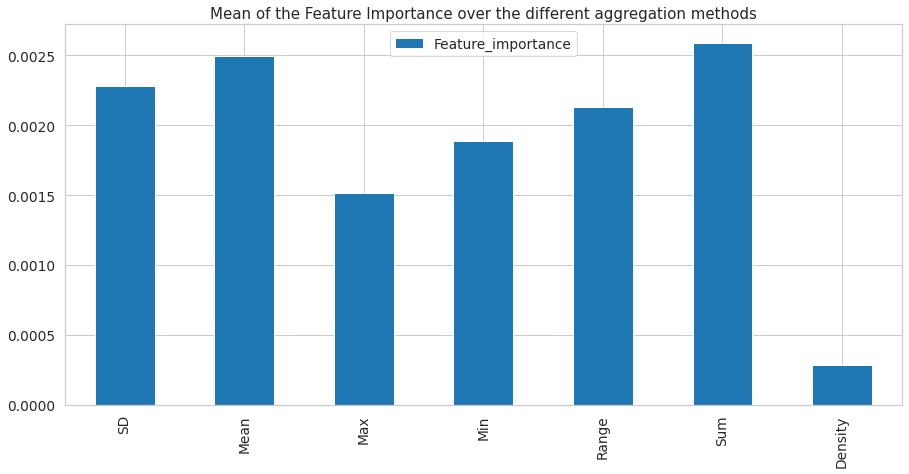

In [46]:
aggregations_importance.plot(kind='bar')
plt.title('Mean of the Feature Importance over the different aggregation methods')
plt.show()

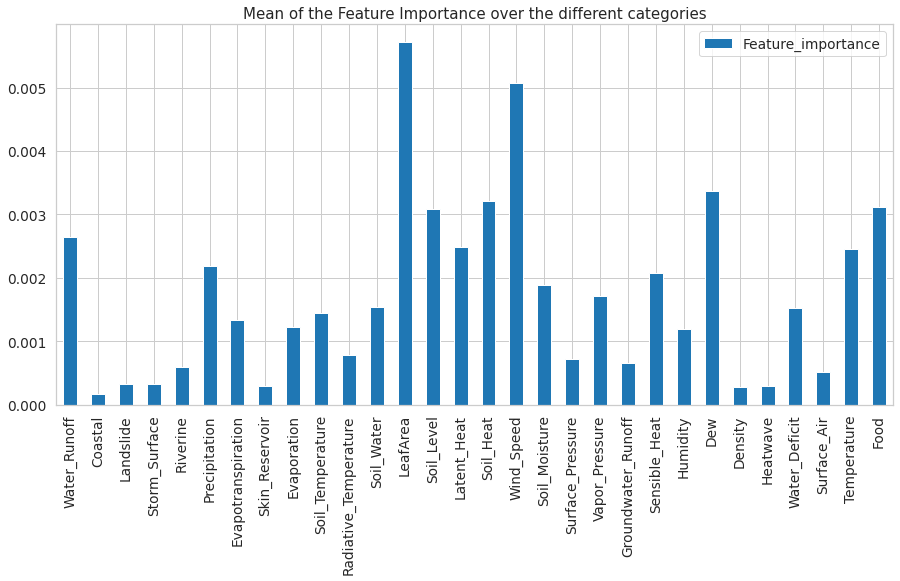

In [47]:
categories_importance.plot(kind='bar')
plt.title('Mean of the Feature Importance over the different categories')
plt.show()

The results are absolutely not conclusive because one feature may take away the predictive power of other features in the random forest model if they are a high leaf in the forest tree, meaning the mean of a category may be lower because all the predictive power has been incorporated in one feature. This is why we consider the maximum as well.

### Calculate the max feature importance of these groups

In [51]:
max_aggregations = [feature_performance.loc[col].max() for col in list(grouped_columns_aggregations.values())]
aggregations_importance_max = pd.DataFrame(index=grouped_columns_aggregations.keys(), data = max_aggregations)

max_categories = [feature_performance.loc[col].max() for col in list(grouped_columns_category.values())]
categories_importance_max = pd.DataFrame(index=grouped_columns_category.keys(), data = max_categories)

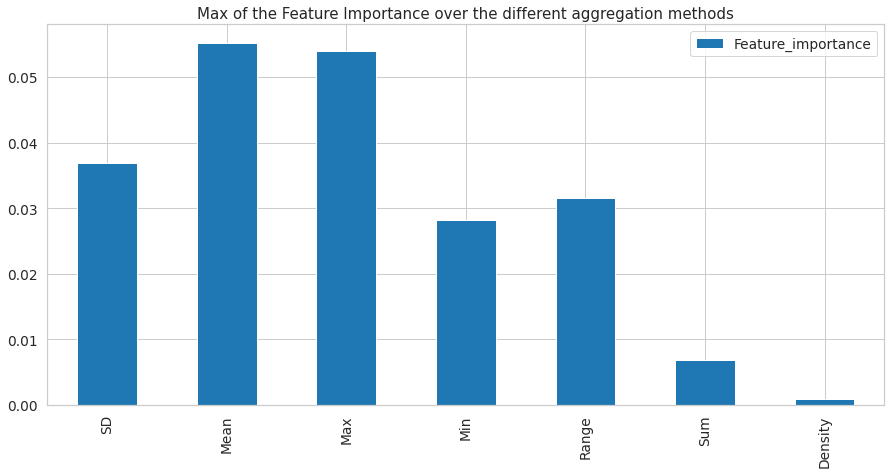

In [52]:
aggregations_importance_max.plot(kind='bar')
plt.title('Max of the Feature Importance over the different aggregation methods')
plt.show()

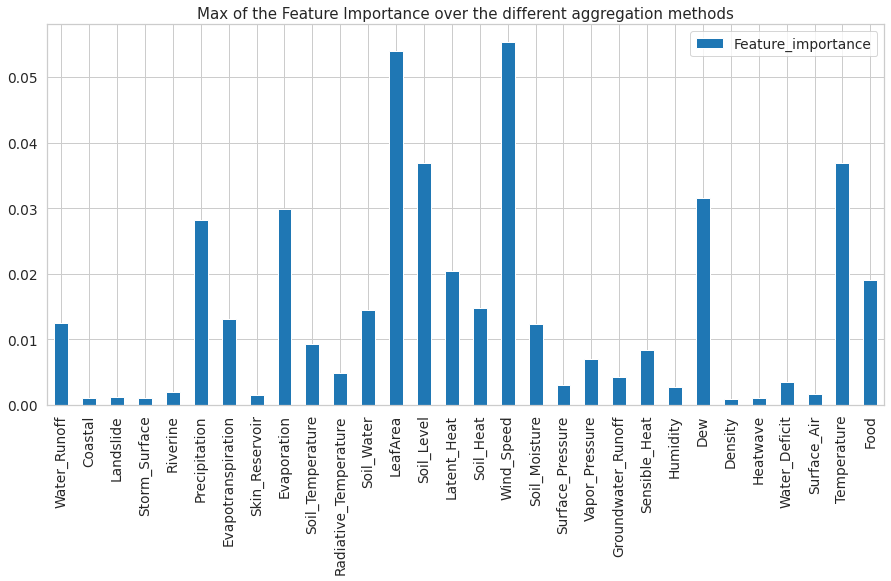

In [53]:
categories_importance_max.plot(kind='bar')
plt.title('Max of the Feature Importance over the different aggregation methods')
plt.show()

Considering both meaning and maxing the feature performance of the aggregations and categories, the conclusion is as follows: the aggregations methods with the most predictive power are mean, max, and standard deviation. The categories with the most predictive power are food, temperature, dew, sensible heat, wind speed, soil heat, latent heat, soil level, leafarea, evaporation, evapotranspiration, precipitation, water runoff.